In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import vgg16, vgg16_bn, resnet18, resnet34, resnet50, resnet101

from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
from sklearn.metrics import f1_score

import seaborn as sn

from os import listdir
from PIL import Image
from collections import defaultdict
import csv
import re

from IPython.display import display, clear_output, Image as IPython_Image

In [2]:
torch.cuda.is_available()

True

# Data loading

In [3]:
IMAGE_PATH = '../data/images'
LABEL_PATH = '../data/annotations'

# GIVEN DATASET
MEAN = (0.43672, 0.40107, 0.36762)
STD = (0.30139, 0.28781, 0.29236)

# IMAGENET
#MEAN = (0.485, 0.456, 0.406)
#STD = (0.229, 0.224, 0.225)

# RESNET
#MEAN = (0.485, 0.456, 0.406)
#STD = (0.229, 0.224, 0.225)
       
# Define default pos_weights for nn.BCEWithLogitsLoss(pos_weights). If the get_dataloader() is run, is will 
# overwrite this variable based on the statistics of the test set.
label_pos_weights_for_loss = np.array([209.52631579, 55.87203791, 58.40594059, 16.77777778, 44.80152672, 5.25, 25.14379085, 5.75675676, 33.09090909, 2.15540363, 5.51465798, 163.38356164, 119., 37.46153846], dtype=np.float32)

In [4]:
def number_of_classes():
    return len(listdir(LABEL_PATH))

In [5]:
def get_class_map():
    ret = {}

    i = 0
    for fname in listdir(LABEL_PATH):
        img_class, _ = fname.split('.')
        ret[img_class] = i
        i += 1

    return ret

In [6]:
def write_labels_to_csv(name_of_set, label_array):
    filepath = f'../data/labels_{name_of_set}.csv'
    
    label_arr = np.array(label_array).astype(int)

    # Save 2D numpy array to csv file
    np.savetxt(filepath, label_arr, delimiter=',', fmt='%d')

In [7]:
def calculate_label_statistics(label_array, total_n_images):
    label_arr = np.array(label_array).astype(int)
    pos_label_counts_all = np.sum(label_arr, axis=0)
    neg_label_counts_all = total_n_images - pos_label_counts_all
    relative_label_occurrances =  pos_label_counts_all/total_n_images
    pos_weights = neg_label_counts_all / pos_label_counts_all
    
    return pos_weights, pos_label_counts_all, neg_label_counts_all, relative_label_occurrances

In [8]:
def print_label_statistics(name_of_set, pos_weights, pos_label_counts_all, neg_label_counts_all, relative_label_occurrances):    
    print(f'\nData set: {name_of_set}')
    print(' Positive label counts\n  ', pos_label_counts_all)
    print(' Negative label counts\n  ', neg_label_counts_all)
    print(' Relative label occurrances\n  ', relative_label_occurrances)
    print(' Pos_weights\n  ', pos_weights)

In [9]:
def get_dataloader(bs=256, train_fr=.6, max_images_per_class=1e9, use_no_label_imgs = True, transformations=None):
    
    # by default only transform to tensor
    if transformations is None:
        transformations = transforms.Compose([transforms.ToTensor()])
    
    # mapping from class names to integers
    class_map = get_class_map()

    # create a dictionary to hold our label vectors
    n_classes = len(class_map.keys())
    img_to_class = defaultdict(lambda: np.zeros(n_classes))

    # another dictionary to hold the actual image data
    img_to_data = dict()
    
    # loop through all the annotations
    for fname in listdir(LABEL_PATH):
        img_class, _ = fname.split('.')
        print(f'Reading class: {img_class}')
        
        # open the annotation file
        with open(f'{LABEL_PATH}/{fname}', 'r') as fh:

            # get image ids from annotation file
            img_ids = fh.read().splitlines()
            
            # gather the images with labels
            for i, img_id in enumerate(img_ids):
                
                # let's not process images unnecessarily
                if not img_id in img_to_data:

                    img_path = f'{IMAGE_PATH}/im{img_id}.jpg'
                    img = Image.open(img_path)

                    # apply transformations
                    img_tensor = transformations(img.convert('RGB')).numpy()

                    # append to dict
                    img_to_data[img_id] = img_tensor

                # get one-hot encoded vector of image classes
                img_classes = img_to_class[img_id]

                # add new class to image vector
                img_class_id = class_map[img_class]
                img_classes[img_class_id] = 1

                # store the updated vector back
                img_to_class[img_id] = img_classes

                if i >= max_images_per_class:
                    break
                i += 1

    # If use_no_label_imgs is on, load also all the images that do not have any labels
    i = 0
    for fname in listdir(IMAGE_PATH):
        m = re.match('im(\d+)', fname)
        img_id = m.group(1)

        if img_id not in img_to_data:
            img_path = f'{IMAGE_PATH}/im{img_id}.jpg'
            img = Image.open(img_path)

            # apply transformations
            img_tensor = transformations(img.convert('RGB')).numpy() 

            # append to dict
            img_to_data[img_id] = img_tensor

            if i >= max_images_per_class:
                break
            i += 1

    # collect data to a single array
    X = []
    y = []
    for img_id in img_to_data.keys():
        X.append(img_to_data[img_id])
        y.append(img_to_class[img_id])

    X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, train_size=train_fr, random_state=42)
    X_test, X_valid, y_test, y_valid = train_test_split(X_tmp, y_tmp, train_size=.5, test_size=.5, random_state=42)
    
    # Write labels to csv file
    #write_labels_to_csv('all', y)
    #write_labels_to_csv('train', y_train)
    #write_labels_to_csv('validation', y_valid)
    #write_labels_to_csv('test', y_test)
    
    # Calculate and print out label statistics to be able to analyze label imbalance
    pos_weights_all, pos_label_counts_all, neg_label_counts_all, relative_label_occurrances_all = calculate_label_statistics(y, len(X))
    pos_weights_train, pos_label_counts_train, neg_label_counts_train, relative_label_occurrances_train = calculate_label_statistics(y_train, len(X_train))
    pos_weights_valid, pos_label_counts_valid, neg_label_counts_valid, relative_label_occurrances_valid = calculate_label_statistics(y_valid, len(X_valid))
    pos_weights_test, pos_label_counts_test, neg_label_counts_test, relative_label_occurrances_test = calculate_label_statistics(y_test, len(X_test))
    
    print_label_statistics('all', pos_weights_all, pos_label_counts_all, neg_label_counts_all, relative_label_occurrances_all)
    print_label_statistics('train', pos_weights_train, pos_label_counts_train, neg_label_counts_train, relative_label_occurrances_train)
    print_label_statistics('validation', pos_weights_valid, pos_label_counts_valid, neg_label_counts_valid, relative_label_occurrances_valid)
    print_label_statistics('test', pos_weights_test, pos_label_counts_test, neg_label_counts_test, relative_label_occurrances_test)
    
    # Set the pos_weights to be used in the loss function
    label_pos_weights_for_loss = pos_weights_train
    
    train_dataloader = DataLoader(TensorDataset(
        torch.tensor(X_train, dtype=torch.float),
        torch.tensor(y_train, dtype=torch.float)),
        shuffle=True,
        batch_size=bs)           

    valid_dataloader = DataLoader(TensorDataset(
        torch.tensor(X_valid, dtype=torch.float),
        torch.tensor(y_valid, dtype=torch.float)),
        shuffle=True,
        batch_size=bs)

    test_dataloader = DataLoader(TensorDataset(
        torch.tensor(X_test, dtype=torch.float),
        torch.tensor(y_test, dtype=torch.float)),
        shuffle=True,
        batch_size=bs)      

    return train_dataloader, valid_dataloader, test_dataloader

# Models

In [10]:
class TwoLayerModel(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_classes):
        super().__init__()
        self.bs = bs
        self.input_layer = nn.Linear(n_input, n_hidden1)
        self.hidden1 = nn.Linear(n_hidden1, n_hidden2)
        self.hidden2 = nn.Linear(n_hidden2, n_classes)
        self.relu = nn.ReLU()
        self.bn0 = nn.BatchNorm1d(n_input)
        self.bn1 = nn.BatchNorm1d(n_hidden1)
        self.bn2 = nn.BatchNorm1d(n_hidden2)

    def forward(self, x):
        x = self.bn0(x)
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.hidden2(x)

        return x

In [11]:
class OneLayerModel(nn.Module):
    def __init__(self, n_input, n_hidden, n_classes):
        super().__init__()

        self.input_layer = nn.Linear(n_input, n_hidden)
        self.hidden = nn.Linear(n_hidden, n_classes)
        self.relu = nn.ReLU()
        self.bn0 = nn.BatchNorm1d(n_input)
        self.bn1 = nn.BatchNorm1d(n_hidden)

    def forward(self, x):
        print(f'X.SHAPE: {x.shape}')
        x = self.bn0(x)
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.hidden(x)

        return x

In [12]:
class ConvNetModel(nn.Module):
    def __init__(self, n_classes, keep_prob=.5):
        super(ConvNetModel, self).__init__()
        # Common layers used multiple times
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=1-keep_prob)
        
        # Unique layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3, stride=1, padding=1) #(n samples, channels, height, width)
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=14, kernel_size=3, stride=1, padding=1)
        self.fc3 = nn.Linear(in_features=256*4*14, out_features=n_classes)
        
    def forward(self, x):
        x = x.reshape(-1, 3, 128, 128)
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        
        out = out.reshape(out.size(0), -1)  # Flatten for FC
        out = self.fc3(out)
        return out    

# Training and evaluation functions

In [13]:
def evaluate(dataloader, model, criterion, device, threshold=0.5):
    model.eval()

    f1_scores = []
    losses = []

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)

            loss = criterion(y_pred, y)
            losses.append(loss)

            with torch.no_grad():
                score = f1_score(y.cpu() == 1, y_pred.cpu() > threshold, average='micro')
                f1_scores.append(score)

    model.train()

    return torch.mean(torch.tensor(losses)), torch.mean(torch.tensor(f1_scores))

In [14]:
def train(train_dataloader, valid_dataloader, model, optimizer, scheduler, criterion, device, n_epochs=50, verbose=True):
    model.train()

    if verbose:
        fmt = '{:<5} {:12} {:12} {:<9} {:<9}'
        print(fmt.format('Epoch', 'Train loss', 'Valid loss', 'Train F1', 'Valid F1'))

    for epoch in range(n_epochs):
        
        for i, batch in enumerate(train_dataloader):
            X, y = batch
            
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            print(f'Epoch: {epoch+1}, iteration: {i+1}, loss: {loss}')

        if verbose:
            train_loss, train_score = evaluate(train_dataloader, model, criterion, device)
            valid_loss, valid_score = evaluate(valid_dataloader, model, criterion, device)

            fmt = '{:<5} {:03.10f} {:03.10f} {:02.7f} {:02.7f}'
            print(fmt.format(epoch, train_loss, valid_loss, train_score, valid_score))
            
    print('Done training!')

In [15]:
def visualize_predictions(model, device, dataloader, mean=MEAN, std=STD, n_to_show=3, threshold=0.5):
    
    class_to_label = { v: k for k, v in get_class_map().items() }
    
    # https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/5
    inv_transform = transforms.Compose([
        transforms.Normalize(mean = -1 * np.multiply(mean, std), std=np.divide(1, std))
    ])
    
    for i, batch in enumerate(dataloader):
        n_shown = 0
        
        X, y = batch
        X = X.to(device)

        y_pred_raw = model(X).cpu()
        y_pred = y_pred_raw > threshold 
        y = y == 1

        for i in range(len(y)):
            pred_classes = np.where(y_pred[i] == 1)[0]
            true_classes = np.where(y[i] == 1)[0]
            
            true_classes_str = ', '.join([class_to_label[i] for i in true_classes])
            pred_classes_str = ', '.join([class_to_label[i] for i in pred_classes])

            img = inv_transform(X[i].cpu())              # inverse transforms
            img = img.permute(2, 1, 0)                   # BGR -> RGB
            img = np.rot90(img, 3)
                                    
            plt.title(f'True: {true_classes_str}, Predictions: {pred_classes_str}')
            plt.imshow(img)
            plt.pause(0.001)

            if n_shown >= n_to_show:
                return

            n_shown += 1

It would be nice to use same naming conventions everywhere. Might be a good idea to rename `y_hat` to `y_pred` or vice versa everywhere (it makes it easier to combine the notebooks). I don't care which way it is. Also the `Xs` and `ys` etc.

In [16]:
def predict_X(fr, threshold=0.5):
    
    y_hat = fr > threshold
    
    return y_hat if (np.sum(y_hat) > 0) else fr == np.max(fr)

def predict(model, device, dataloader):
    
    ys_all = []  # Array of np.array(14) 
    y_hats_all = []
    
    for i, batch in enumerate(dataloader):
        
        Xs, ys = batch
        Xs = model(Xs.to(device))
        y_hats = np.apply_along_axis(predict_X, axis=1, arr=Xs.cpu().detach().numpy())
        
        y_hats_all.extend(y_hat for y_hat in y_hats)
        ys_all.extend(y.numpy() for y in ys==1)

    return np.array(ys_all), np.array(y_hats_all)

def visualize_confusion_matrix(y_true, y_pred, labels, file_path):

    plt.ioff()
    
    # Get confusion matrices
    cn_tensor = skm.multilabel_confusion_matrix(y_true, y_pred)
    
    # Get precision, recall, f1-score
    scores = skm.classification_report(y_true, y_pred, output_dict=True)

    fig, ax = plt.subplots(nrows=5, ncols=3,sharey=True, figsize=(20, 20), 
                           gridspec_kw={'hspace': 0.3, 'wspace': 0.0})
    gn = ['True Neg','False Pos','False Neg','True Pos']
    n = cn_tensor[0].sum()
    
    # Loop all labels
    for i, cn_matrix in enumerate(cn_tensor):

        j, k = int(i/3), i%3
        
        # Annotations
        annot = np.asarray(
            ['{}\n{:0.0f}\n{:.2%}'.format(gn[i], x, x/n) for i, x in enumerate(cn_matrix.flatten())]
        ).reshape(2,2)
        
        # Plot heatmap
        sn.heatmap(cn_matrix, annot=annot, fmt='', cmap='Blues', ax=ax[j, k])
        
        # Precision, recall, f1-score
        title = '{}\nprec.={:.3}, rec.={:.3}, f1={:.3}'.format(
            labels[i], scores[str(i)]['precision'], scores[str(i)]['recall'], scores[str(i)]['f1-score'])
        ax[j, k].set_title(title)
        
    plt.savefig(file_path, bbox_inches='tight')
    plt.close()

# Do the magic!

In [17]:
if torch.cuda.is_available():
    print('Using GPU!')
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

lr = 0.01
n_epochs = 20
bs = 64
n_classes = len(get_class_map().keys())

Using GPU!


## Create and save / load dataloaders from disk

If you want to test the models that do not seem to work with 128x128 images change the transformation to do the resize.

However, it should be investigated if, for example RESNET, can be made to work with 128x128 images.

In [18]:
use_no_label_imgs = True
max_images_per_class = 1e9
#max_images_per_class = 200
affix = "_" + str(max_images_per_class) if max_images_per_class < 1e9 else ""

transformations = {
    'train': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ]),
    'valid': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ]),
    'test': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ]),
}

# Data augmentation testing.
#
# At least this did not work. Probably some transform hurts it?
#
# transformations = {
#     'train': transforms.Compose([
#                 torchvision.transforms.RandomApply([
#                     transforms.ColorJitter(0.3, 0.3, 0.3),
#                     transforms.Grayscale(3),
#                     transforms.RandomHorizontalFlip(),
#                     transforms.RandomPerspective(),
#                     transforms.RandomRotation((-30, 30)),
#                 ]),
#                 transforms.ToTensor(),
#                 transforms.RandomErasing(),
#                 transforms.Normalize(mean=MEAN, std=STD),
#             ]),
#     'valid': transforms.Compose([
#                 transforms.ToTensor(),
#                 transforms.Normalize(mean=MEAN, std=STD)
#             ]),
#     'test': transforms.Compose([
#                 transforms.ToTensor(),
#                 transforms.Normalize(mean=MEAN, std=STD)
#             ]),
# }

try:
    train_dataloader = torch.load(f'../data/train_dataloader{affix}.dat')
    valid_dataloader = torch.load(f'../data/valid_dataloader{affix}.dat')
    test_dataloader = torch.load(f'../data/test_dataloader{affix}.dat')
except:
    train_dataloader, valid_dataloader, test_dataloader = get_dataloader(
        bs=bs, 
        transformations=transformations['train'],
        max_images_per_class=max_images_per_class,
        use_no_label_imgs=use_no_label_imgs
    )
    torch.save(train_dataloader, f'../data/train_dataloader{affix}.dat')
    torch.save(valid_dataloader, f'../data/valid_dataloader{affix}.dat')
    torch.save(test_dataloader, f'../data/test_dataloader{affix}.dat')

## Pretrained models

NB: The mean and std in transformations most probably need to be the same as for VGG and RESNET. Not 100% sure about this. Something to investigate!

More models here: https://pytorch.org/docs/stable/torchvision/models.html

If the models do not start to converge, try lowering the learning rate!

_VGG16_

Currently getting validation f1 scores around 0.67.

Surprisingly after quick testing the vgg16_bn (with BatchNorm layers) did not do as well? Maybe more to investigate here.

In [30]:
if False:
    model = vgg16(pretrained=True).to(device)

    for param in model.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(
        # PyTorch 1.4.0 and related libraries
        # seem to produce 8192 output to fc?
        # Don't know why.
        #nn.Linear(8192, 4096),
        
        # This is for recent PyTorch
        nn.Linear(25088, 4096),
        nn.ReLU(),
        nn.Linear(4096, 2048),
        nn.ReLU(),
        nn.Linear(2048, 14),
    ).to(device)

_RESNET_


In [20]:
if False:
    model = resnet18(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(512, 14).to(device)

In [21]:
if False:
    model = resnet34(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(512, 14).to(device)

In [22]:
if False:
    model = resnet50(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(2048, 14).to(device)

In [31]:
if True:
    model = resnet101(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(2048, 14).to(device)

## Train a model or load an existing model from disk

In [24]:
n_epochs = 5

In [32]:
#model_path = '../data/TwoLayerModel_state.dict'
model_path = f'../data/ConvNetModel_state{affix}.dict'

#model = OneLayerModel(224*224*3, 256, n_classes).to(device)
#model = TwoLayerModel(128*128*3, 512, 256, n_classes).to(device)
#model = ConvNetModel(n_classes=n_classes, keep_prob=.5).to(device)

# loss function
pos_weight = torch.from_numpy(label_pos_weights_for_loss).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# learning rate and momentum will be overriden by the scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# scheduler
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00001, max_lr=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    #max_lr=0.01,
    max_lr=0.00001,
    base_momentum=0.5,
    max_momentum=0.99,
    steps_per_epoch=len(train_dataloader),
    epochs=n_epochs,
)

In [33]:
# Plain model saving and loading.
#model_save_path = '../data/resnet-valid-acc-0.71.pth'
#model_save_path = '../data/vgg16-valid-acc-0.71.pth'
#torch.save(model.state_dict(), model_save_path)
#model.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [34]:
# This is for trying to train all the layers...
#for param in model.parameters():
#    param.requires_grad = True

In [35]:
%time train(train_dataloader, valid_dataloader, model, optimizer, scheduler, criterion, device, n_epochs=n_epochs)

Epoch Train loss   Valid loss   Train F1  Valid F1 
Epoch: 1, iteration: 1, loss: 0.10560436546802521
Epoch: 1, iteration: 2, loss: 0.05744187533855438
Epoch: 1, iteration: 3, loss: 0.07032783329486847
Epoch: 1, iteration: 4, loss: 0.07952552288770676
Epoch: 1, iteration: 5, loss: 0.06765979528427124
Epoch: 1, iteration: 6, loss: 0.12789495289325714
Epoch: 1, iteration: 7, loss: 0.10930977016687393
Epoch: 1, iteration: 8, loss: 0.05842842534184456
Epoch: 1, iteration: 9, loss: 0.0817381963133812
Epoch: 1, iteration: 10, loss: 0.08478190004825592
Epoch: 1, iteration: 11, loss: 0.07978487014770508
Epoch: 1, iteration: 12, loss: 0.06648324429988861
Epoch: 1, iteration: 13, loss: 0.0825672447681427
Epoch: 1, iteration: 14, loss: 0.11494650691747665
Epoch: 1, iteration: 15, loss: 0.05585272237658501
Epoch: 1, iteration: 16, loss: 0.0705433189868927
Epoch: 1, iteration: 17, loss: 0.1088765561580658
Epoch: 1, iteration: 18, loss: 0.13423509895801544
Epoch: 1, iteration: 19, loss: 0.0535463131

Epoch: 1, iteration: 160, loss: 0.06967856734991074
Epoch: 1, iteration: 161, loss: 0.10728630423545837
Epoch: 1, iteration: 162, loss: 0.0617130808532238
Epoch: 1, iteration: 163, loss: 0.07272521406412125
Epoch: 1, iteration: 164, loss: 0.040232595056295395
Epoch: 1, iteration: 165, loss: 0.06367674469947815
Epoch: 1, iteration: 166, loss: 0.0600108876824379
Epoch: 1, iteration: 167, loss: 0.08609011024236679
Epoch: 1, iteration: 168, loss: 0.06092201545834541
Epoch: 1, iteration: 169, loss: 0.05897323787212372
Epoch: 1, iteration: 170, loss: 0.06027953699231148
Epoch: 1, iteration: 171, loss: 0.08314771950244904
Epoch: 1, iteration: 172, loss: 0.07813709229230881
Epoch: 1, iteration: 173, loss: 0.07883480191230774
Epoch: 1, iteration: 174, loss: 0.11015263944864273
Epoch: 1, iteration: 175, loss: 0.08439979702234268
Epoch: 1, iteration: 176, loss: 0.049383554607629776
Epoch: 1, iteration: 177, loss: 0.09496868401765823
Epoch: 1, iteration: 178, loss: 0.09935017675161362
Epoch: 1, it

Epoch: 2, iteration: 131, loss: 0.08844078332185745
Epoch: 2, iteration: 132, loss: 0.09892795979976654
Epoch: 2, iteration: 133, loss: 0.0970565602183342
Epoch: 2, iteration: 134, loss: 0.07816445827484131
Epoch: 2, iteration: 135, loss: 0.13235926628112793
Epoch: 2, iteration: 136, loss: 0.058801840990781784
Epoch: 2, iteration: 137, loss: 0.050190333276987076
Epoch: 2, iteration: 138, loss: 0.07973163574934006
Epoch: 2, iteration: 139, loss: 0.09241560846567154
Epoch: 2, iteration: 140, loss: 0.1649293452501297
Epoch: 2, iteration: 141, loss: 0.08803481608629227
Epoch: 2, iteration: 142, loss: 0.08329115808010101
Epoch: 2, iteration: 143, loss: 0.08390418440103531
Epoch: 2, iteration: 144, loss: 0.08633896708488464
Epoch: 2, iteration: 145, loss: 0.05805079638957977
Epoch: 2, iteration: 146, loss: 0.05198505148291588
Epoch: 2, iteration: 147, loss: 0.06503746658563614
Epoch: 2, iteration: 148, loss: 0.09409371763467789
Epoch: 2, iteration: 149, loss: 0.06584757566452026
Epoch: 2, it

KeyboardInterrupt: 

In [37]:
evaluate(valid_dataloader, model, criterion, device, threshold=0.75)

(tensor(2.0792), tensor(0.7163, dtype=torch.float64))

threshold: 0.05, f1 score: 0.7044504755891097
threshold: 0.1, f1 score: 0.7055808412475971
threshold: 0.15000000000000002, f1 score: 0.7066266527075641
threshold: 0.2, f1 score: 0.7067795931563701
threshold: 0.25, f1 score: 0.7083103598060155
threshold: 0.3, f1 score: 0.7098791959478054
threshold: 0.35000000000000003, f1 score: 0.7103132107513113
threshold: 0.4, f1 score: 0.7102839528401126
threshold: 0.45, f1 score: 0.7109055096112386
threshold: 0.5, f1 score: 0.7120718465969099
threshold: 0.55, f1 score: 0.7145170264729985
threshold: 0.6000000000000001, f1 score: 0.7155673869911106
threshold: 0.6500000000000001, f1 score: 0.7145774917884963
threshold: 0.7000000000000001, f1 score: 0.7144314489450548
threshold: 0.7500000000000001, f1 score: 0.7145408195536155
threshold: 0.8, f1 score: 0.7183323315335612
threshold: 0.8500000000000001, f1 score: 0.7173298257250014
threshold: 0.9000000000000001, f1 score: 0.7171387814442962
threshold: 0.9500000000000001, f1 score: 0.719481831716739


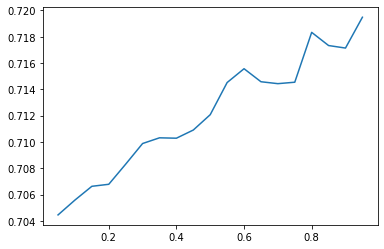

In [38]:
# This is for finding the optimal threshold.
# Haven't proved out to be very useful yet.
if True:
    f1_scores = []
    for threshold in np.arange(0.05, 1, 0.05):
        _, f1 = evaluate(valid_dataloader, model, criterion, device, threshold=threshold)
        f1_scores.append(f1)
        print(f'threshold: {threshold}, f1 score: {f1}')

    plt.plot(np.arange(0.05, 1, 0.05), f1_scores)

# Visualization and evaluation

### Show some images with predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


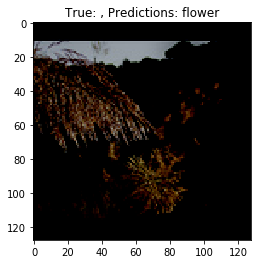

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


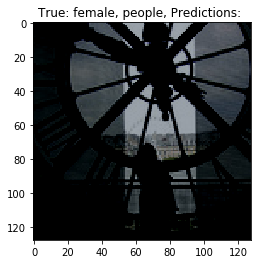

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


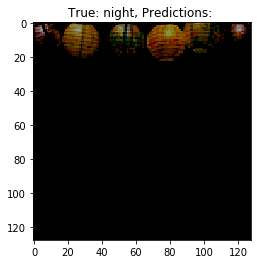

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


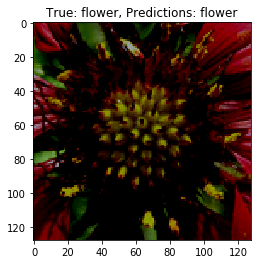

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


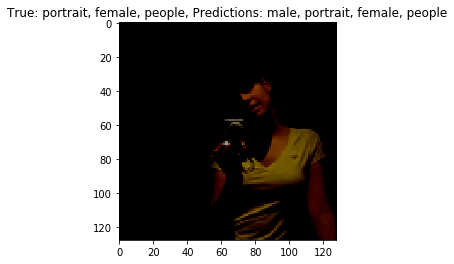

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


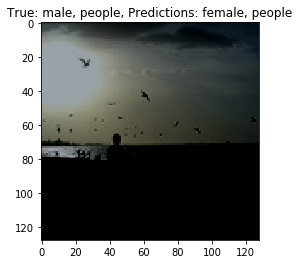

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


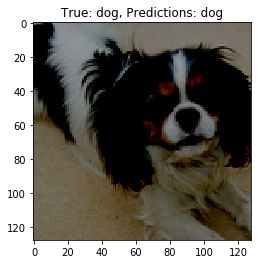

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


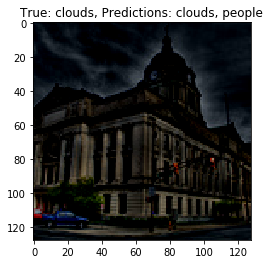

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


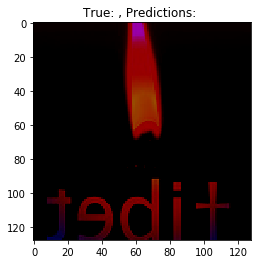

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


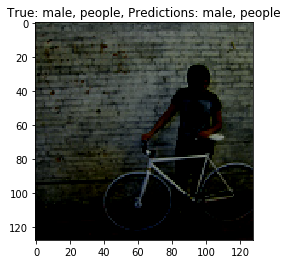

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


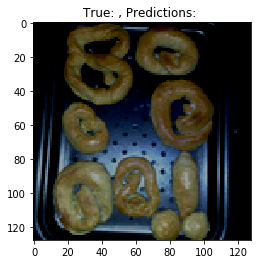

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


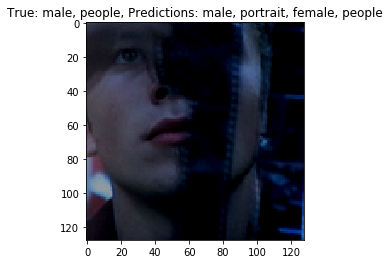

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


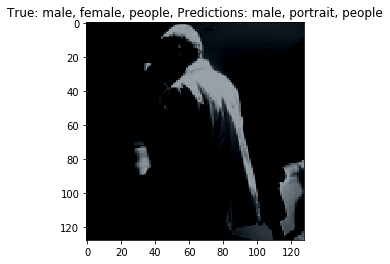

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


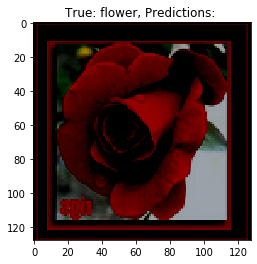

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


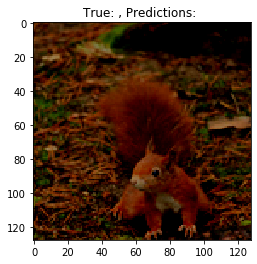

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


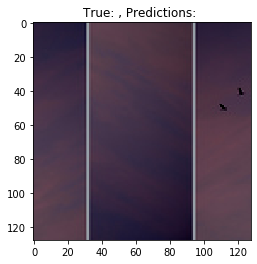

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


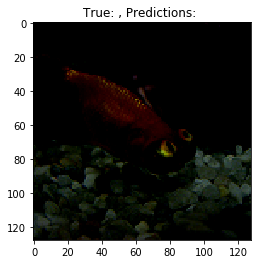

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


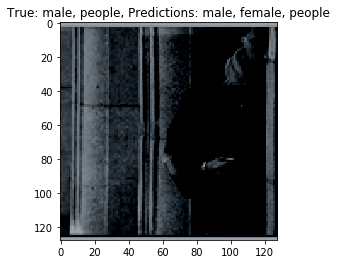

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


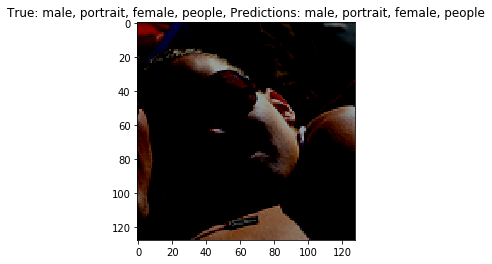

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


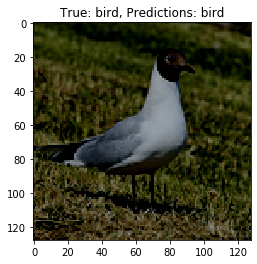

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


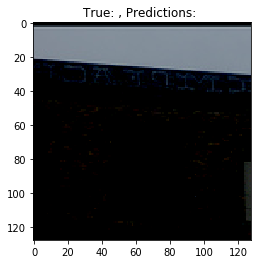

In [39]:
visualize_predictions(model, device, valid_dataloader, n_to_show=20)

### Confusion matrix

In [40]:
re_predict = True

if re_predict:

    # Predict
    y_true, y_pred = predict(model, device, valid_dataloader)
    np.save(f'../data/valid_true_labels{affix}.npy', y_true)
    np.save(f'../data/valid_pred_labels{affix}.npy', y_pred)
    
    # Save classification report
    with open(f'../data/valid_classification_report{affix}.txt', 'w') as file:
        file.write(skm.classification_report(y_true, y_pred))
    
    # Save confusion matrix plot
    labels = [k for k, v in get_class_map().items()]
    visualize_confusion_matrix(y_true, y_pred, labels, f'../data/valid_confusion_matrix{affix}.png')

/home/akir/anaconda3/envs/dl/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
# Show classification report
with open(f'../data/valid_classification_report{affix}.txt', 'r') as file:
    report = ''.join(file.readlines())
    print(report)

              precision    recall  f1-score   support

           0       0.15      0.52      0.23        23
           1       0.49      0.92      0.64       213
           2       0.25      0.44      0.32         9
           3       0.36      0.78      0.50        74
           4       0.38      0.79      0.52        91
           5       0.19      0.65      0.29        77
           6       0.38      0.91      0.53       158
           7       0.57      0.67      0.62       614
           8       0.71      0.84      0.77       635
           9       0.41      0.65      0.51       113
          10       0.30      0.79      0.44       130
          11       0.49      0.83      0.61       647
          12       0.58      0.94      0.72      1303
          13       0.37      0.61      0.46        38

   micro avg       0.51      0.84      0.63      4125
   macro avg       0.40      0.74      0.51      4125
weighted avg       0.54      0.84      0.65      4125
 samples avg       0.41   

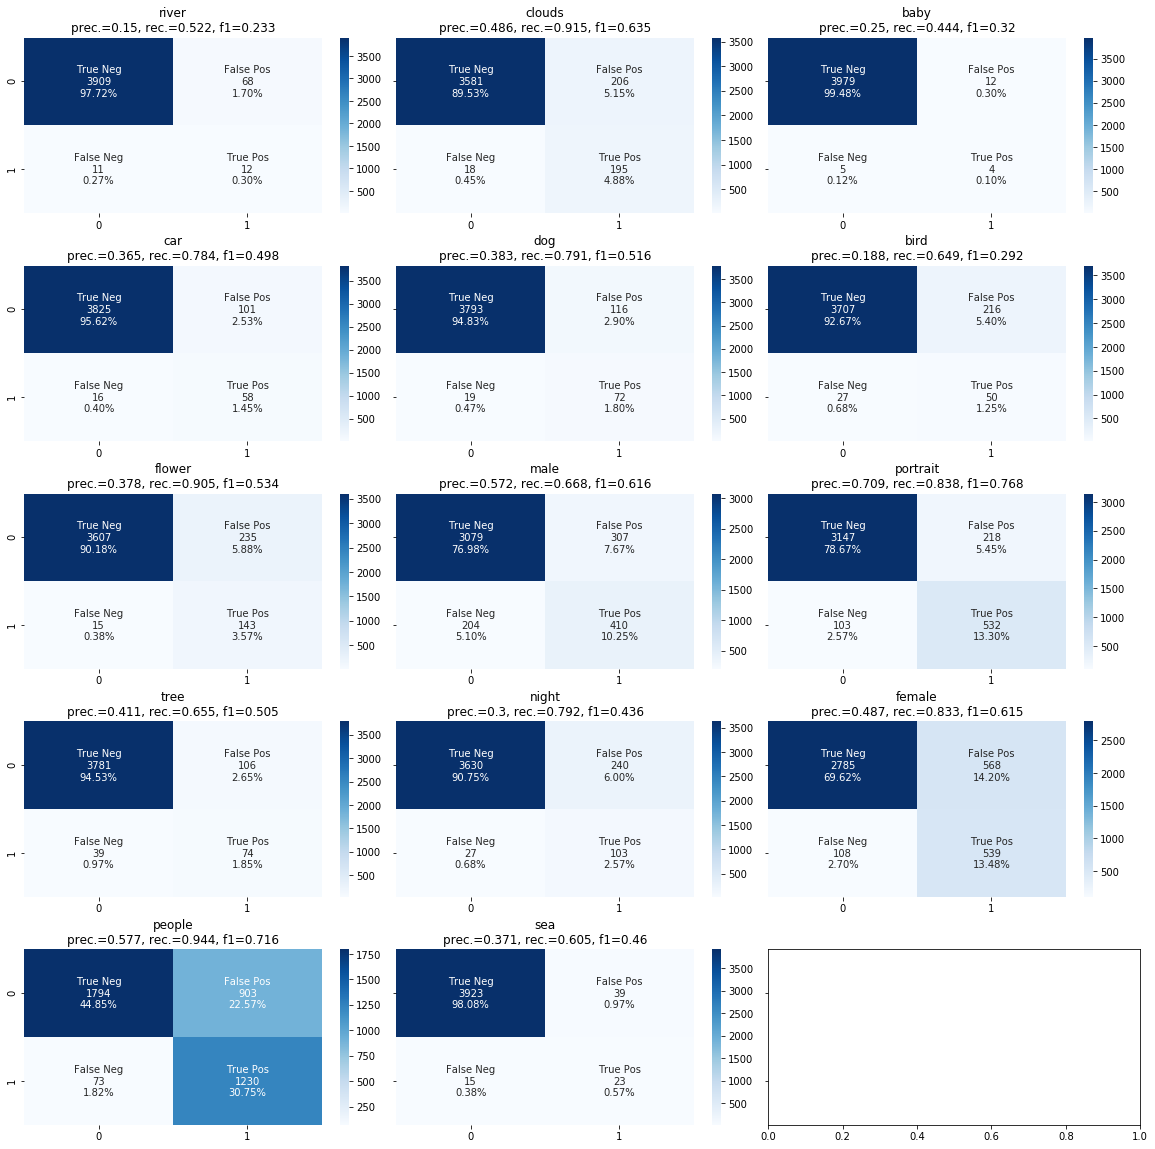

In [42]:
# Show confus|ion matrix plot
IPython_Image(filename=f'../data/valid_confusion_matrix{affix}.png', width=1000)